In [1]:
# Author: Arthur Prigent
# Email: aprigent@geomar.de

In [2]:
import xarray as xr 
#import xgcm 
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import glob
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mticker
import cartopy
from scipy import stats
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime
now = datetime.now()
def data_sub(data,lon_min,lon_max,lat_min,lat_max):
    
    '''Define a box between lon_min lon_max lat_min and lat_max and 
    extract the data in the box and drop everything else.
    
    
    Parameters
    ----------
    
    data : xarray_like
    Data to be subdomained. 
    
    lon_min : integer
    Longitude minimum of the subdomain
    
    lon_max : integer
    Longitude maximum of the subdomain
    
    lat_min : integer
    Latitude minimum of the subdomain
    
    lat_max : integer
    Latitude maximum of the subdomain
    
    Returns
    ---------
    
    data_sub : xarray_like
    Subdomain. 
    '''
    
    try:
        data_sub = data.where((  data.lon>=lon_min) & (data.lon<=lon_max) & (data.lat<=lat_max) & (data.lat>=lat_min),
                                                                          drop=True)
    except AttributeError:
        try:
            data_sub = data.where((  data.nav_lon>=lon_min) & (data.nav_lon<=lon_max) & (data.nav_lat<=lat_max) & (data.nav_lat>=lat_min),drop=True)
        except AttributeError:
            try:
                data_sub = data.where((  data.longitude>=lon_min) & (data.longitude<=lon_max) & (data.latitude<=lat_max) & (data.latitude>=lat_min),drop=True)
            except AttributeError:
                try:
                    data_sub = data.where((  data.x>=lon_min) & (data.x<=lon_max) & (data.y<=lat_max) &
                                      (data.y>=lat_min),drop=True)
                except AttributeError:
                    data_sub = data.where((  data.LON>=lon_min) & (data.LON<=lon_max) & (data.LAT<=lat_max) &
                                      (data.LAT>=lat_min),drop=True)
            
    

 
    
    return data_sub
import scipy.optimize as sc_o


def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x -b
    return y_detrended




# List of models and scenarios

In [3]:
model_list_CMIP5=['ACCESS1-0','ACCESS1-3','bcc-csm1-1-m','bcc-csm1-1','BNU-ESM',
            'CanESM2','CCSM4','CESM1-BGC','CESM1-CAM5','CMCC-CM','CMCC-CMS','CNRM-CM5','CSIRO-Mk3-6-0',
            'FGOALS-g2','GFDL-CM3','GFDL-ESM2G','GFDL-ESM2M','GISS-E2-H-CC','GISS-E2-H',
            'GISS-E2-R-CC','GISS-E2-R','HadGEM2-CC','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','IPSL-CM5A-MR','IPSL-CM5B-LR',
            'MIROC-ESM-CHEM','MIROC-ESM','MIROC5','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','NorESM1-M','NorESM1-ME']

scenario_CMIP5=['rcp45','rcp85']


model_list_CMIP6=['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0',
            'CESM2-WACCM','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4','INM-CM4-8',
            'INM-CM5-0','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3',
            'NorESM2-LM','NorESM2-MM']

scenario_CMIP6=['ssp245','ssp585']
model_all = np.hstack([model_list_CMIP5,model_list_CMIP6])


path_fig='/data/user/aprigent/projects/uncertainty_ATL3_ABA/figures/'
path_data_out = '/data/user/aprigent/projects/uncertainty_ATL3_ABA/data/'



x = x(s,m,t) with x representing the Atlantic Nino amplitude

X is the low-pass filtered values of Atlantic Nino amplitude, X$_{f}$ is the long-term trend and $\epsilon$ the internal long-term variability

X(s,m,t) = X$_{f}$(s,m,t) + $\epsilon$(s,m,t) hecne the dimension are s = 3, i.e. 3 scenarios, m =19, 19 models.

In [4]:
running_mean_atl3_tmp_cmip5 = xr.open_dataset(path_data_out+'ATL3_amplitude_CMIP5.nc')
running_mean_atl3_tmp_cmip5['scenario'] = scenario_CMIP6
running_mean_atl3_tmp_cmip6 = xr.open_dataset(path_data_out+'ATL3_amplitude_CMIP6.nc')

running_mean_atl3_tmp = xr.concat([running_mean_atl3_tmp_cmip5,running_mean_atl3_tmp_cmip6],dim='model')

running_mean_atl3 = running_mean_atl3_tmp.sel(time=slice(datetime(1900, 1, 1),datetime(2085, 12, 31)))

# Compute X$_{f}$(s,m,t)

X$_{f}$ is estimated via a polynomial fit calculated over 1900-2085. 

In [5]:

X = np.arange(0,running_mean_atl3.amp_ATL3.shape[2],1)
Xf_tmp = np.ones((running_mean_atl3.amp_ATL3.shape))*np.nan
for i in range(Xf_tmp.shape[0]):
    for j in range(Xf_tmp.shape[1]):
        Y = running_mean_atl3.amp_ATL3[i,j,:]
        p2 = np.polyfit(X,Y,deg=2)
        p3 = np.polyfit(X,Y,deg=3)
        p4 = np.polyfit(X,Y,deg=4)
        p5 = np.polyfit(X,Y,deg=5)

        Xf_n2 = np.polyval(p2,X)
        Xf_n3 = np.polyval(p3,X)
        Xf_n4 = np.polyval(p4,X)
        Xf_n5 = np.polyval(p5,X)

        Xf_tmp[i,j,:] = Xf_n2

In [6]:
Xf = xr.Dataset({'Xf': (['scenario','model','time'], Xf_tmp),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_all),
                              'time':running_mean_atl3.time} )

# Compute $\epsilon$(s,m,t)

$\epsilon$(s,m,t) = X(s,m,t) - X$_{f}$(s,m,t)

In [9]:
epsilon_tmp = np.ones((running_mean_atl3.amp_ATL3.shape))*np.nan
for j in range(epsilon_tmp.shape[0]):
    for i in range(epsilon_tmp.shape[1]):
        epsilon_tmp[j,i,:] = running_mean_atl3.amp_ATL3[j,i,:] - Xf.Xf[j,i,:]
    

In [11]:
epsilon = xr.Dataset({'eps': (['scenario','model','time'], epsilon_tmp),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_all),
                              'time':running_mean_atl3.time} )

# Compute x$_{f}$(s,m,t) 


x$_{f}$(s,m,t) = X$_{f}$(s,m,t) - i(s,m) 
with x$_{f}$(s,m,t) the response of anthropogenic forcing over the period 2005-2085

i(s,m) is the historical average taken over the period 1979-2005

In [13]:
Xfp = Xf.sel(time=slice(datetime(2005, 1, 1),datetime(2085, 12, 31)))
hist_mean = running_mean_atl3.amp_ATL3.sel(time=slice(datetime(1979, 1, 1),datetime(2005, 12, 31))).mean(dim='time')

In [14]:
xf = np.ones((Xfp.Xf.shape))*np.nan
for j in range(xf.shape[0]):
    for i in range(xf.shape[1]):
        xf[j,i,:] = Xfp.Xf[j,i,:] - hist_mean[j,i]
    

# Compute M(t) model uncertainty 

M(t) = 1/N$_{s}$ $\sum_{s}$ std$_m$(x$_{f}$(s,m,t))

In [15]:
M = np.nanmean(np.nanstd(xf,1),0)

# Compute S(t) scenario uncertainty

S(t) =std$_s$( 1/N$_{m}$( $\sum_{m}$ x$_{f}$(s,m,t))

In [16]:
S = np.nanstd(np.nanmean(xf,1),0)


# Compute I(t) internal variability uncertainty

I(t) =1/N$_{s}$ $\sum_{s}$ 1/N$_{m}$ $\sum_{m}$ std$_t$($\epsilon$(s,m,t))

In [17]:
I_tmp = (epsilon.std(dim='time')).mean(dim='model').mean(dim='scenario')
I = np.ones((S.shape[0]))*I_tmp.eps.values

In [18]:
T = M+S+I

rel_M = (M/T)*100
rel_S = (S/T)*100
rel_I = (I/T)*100


In [20]:
index_equals = np.where(rel_I>rel_M)

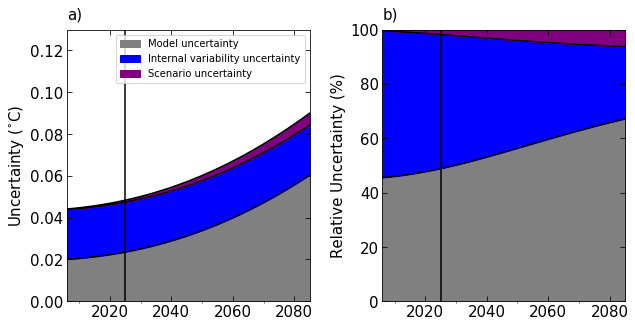

In [21]:
f,ax = plt.subplots(1,2,figsize=[10,5])
ax = ax.ravel()
ftz=15

ax[0].plot(Xfp.time,M,color='black')
ax[0].plot(Xfp.time,M+I,color='black')
ax[0].plot(Xfp.time,M+I+S,color='black')

ax[0].fill_between(Xfp.time.values,0,M,color='grey',label='Model uncertainty')
ax[0].fill_between(Xfp.time.values,M,M+I,color='blue',label='Internal variability uncertainty')
ax[0].fill_between(Xfp.time.values,M+I,M+I+S,color='purple',label='Scenario uncertainty')
ax[0].legend(fontsize=ftz-5)
ax[0].set_ylim([0,0.13])
ax[0].set_xlim([Xfp.time[0].values,Xfp.time.values[-1]])
ax[0].axvline(Xfp.time[index_equals[0][-1]].values,color='black')


ax[0].set_ylabel('Uncertainty ($^{\circ}$C)',fontsize=ftz)
ax[1].plot(Xfp.time,rel_M,color='black')
ax[1].plot(Xfp.time,rel_I+rel_M,color='black')
ax[1].fill_between(Xfp.time.values,0,rel_M,color='grey')
ax[1].fill_between(Xfp.time.values,rel_M,rel_I+rel_M,color='blue')
ax[1].fill_between(Xfp.time.values,rel_I+rel_M,rel_I+rel_M+rel_S,color='purple')

ax[1].set_ylim([0,100])
ax[1].set_ylabel('Relative Uncertainty (%)',fontsize=ftz)
ax[1].set_xlim([Xfp.time[0].values,Xfp.time.values[-1]])

ax[1].axvline(Xfp.time[index_equals[0][-1]].values,color='black')

years = mdates.YearLocator(20)   # every 5 years
years_minor = mdates.YearLocator(10)  # every year
myFmt = mdates.DateFormatter('%Y')
ax[0].xaxis.set_major_locator(years)
ax[0].xaxis.set_minor_locator(years_minor)
ax[0].xaxis.set_major_formatter(myFmt)

ax[0].tick_params(labelsize=ftz)
ax[1].tick_params(labelsize=ftz)
ax[1].xaxis.set_major_locator(years)
ax[1].xaxis.set_minor_locator(years_minor)
ax[1].xaxis.set_major_formatter(myFmt)
plt.subplots_adjust(wspace=0.3)
ax[0].text(0,
         1.04, 'a)',transform=ax[0].transAxes,size=ftz)
ax[1].text(0,
         1.04, 'b)',transform=ax[1].transAxes,size=ftz)

ax[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=True, left=True, right=True,length=5,direction='in')
ax[1].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=True, left=True, right=True,length=5,direction='in')

plt.savefig(path_fig + 'figure_02_uncertainty_ALL.png',
             dpi = 300,
            bbox_inches='tight')

In [22]:
print('Model uncertainty 2085:',np.round(M[-1],3))
print('Internal uncertainty 2085:',np.round(I[-1],3))
print('Scenario uncertainty 2085:',np.round(S[-1],3))

print('Total uncertainty 2085:',np.round(M[-1]+I[-1]+S[-1],2))

Model uncertainty 2085: 0.06
Internal uncertainty 2085: 0.024
Scenario uncertainty 2085: 0.006
Total uncertainty 2085: 0.09


In [23]:
print('Model uncertainty 2005:',np.round(M[0],3))
print('Internal uncertainty 2005:',np.round(I[0],3))
print('Scenario uncertainty 2005:',np.round(S[0],3))

print('Total uncertainty 2005:',np.round(M[0]+I[0]+S[0],2))

Model uncertainty 2005: 0.02
Internal uncertainty 2005: 0.024
Scenario uncertainty 2005: 0.0
Total uncertainty 2005: 0.04


In [24]:
Xfp.time[index_equals[0][-1]].values

numpy.datetime64('2024-12-31T00:00:00.000000000')

In [34]:
print('fraction of uncertainty explained by the internal variability in 2005',np.round(I[0]/(M[0]+I[0]+S[0]),3))

fraction of uncertainty explained by the internal variability in 2005 0.54


In [35]:
print('fraction of uncertainty explained by the model uncertainty in 2085',np.round(M[-1]/(M[-1]+I[-1]+S[-1]),3))

fraction of uncertainty explained by the model uncertainty in 2085 0.672
